In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
from ast import literal_eval

### Data Reading

During this exam, each test taker sees a Standardized Patient, a person trained to portray a clinical case. After interacting with the patient, the test taker documents the relevant facts of the encounter in a patient note. Each patient note is scored by a trained physician who looks for the presence of certain key concepts or features relevant to the case as described in a rubric. The goal of this competition is to develop an automated way of identifying the relevant features within each patient note, with a special focus on the patient history portions of the notes where the information from the interview with the standardized patient is documented.

In [4]:
DATA_DIR = "../data/nbme-score-clinical-patient-notes"
notes_df = pd.read_csv(os.path.join(DATA_DIR, "patient_notes.csv"))
features_df = pd.read_csv(os.path.join(DATA_DIR, "features.csv"))
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
samplesub_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

In [5]:
df = train_df.merge(features_df, how="left", on=["case_num", "feature_num"])
df = df.merge(notes_df, how="left", on=["case_num", "pn_num"])
df["annotation_list"] = [literal_eval(x) for x in train_df["annotation"]]
df["location_list"] = [literal_eval(x) for x in train_df["location"]]
df["pn_history"] = df["pn_history"].apply(lambda x: x.lower())
df["feature_text"] = df["feature_text"].apply(lambda x: x.lower())
df["feature_text"] = df["feature_text"].apply(
    lambda x: x.replace("-", " ").replace("-OR-", ";-")
)

In [6]:
notes_df.nunique()

pn_num        42146
case_num         10
pn_history    42146
dtype: int64

In [7]:
train_df.nunique()

id             14300
case_num          10
pn_num          1000
feature_num      143
annotation      5201
location        7534
dtype: int64

In [8]:
df


,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotation_list,location_list
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],family history of mi or family history of myoc...,hpi: 17yo m presents with palpitations. patien...,[dad with recent heart attcak],[696 724]
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],family history of thyroid disorder,hpi: 17yo m presents with palpitations. patien...,"[mom with ""thyroid disease]",[668 693]
2,00016_002,0,16,2,['chest pressure'],['203 217'],chest pressure,hpi: 17yo m presents with palpitations. patien...,[chest pressure],[203 217]
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",intermittent symptoms,hpi: 17yo m presents with palpitations. patien...,"[intermittent episodes, episode]","[70 91, 176 183]"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],lightheaded,hpi: 17yo m presents with palpitations. patien...,[felt as if he were going to pass out],[222 258]
...,...,...,...,...,...,...,...,...,...,...
14295,95333_912,9,95333,912,[],[],family history of migraines,stephanie madden is a 20 year old woman compla...,[],[]
14296,95333_913,9,95333,913,[],[],female,stephanie madden is a 20 year old woman compla...,[],[]
14297,95333_914,9,95333,914,['photobia'],['274 282'],photophobia,stephanie madden is a 20 year old woman compla...,[photobia],[274 282]
14298,95333_915,9,95333,915,['no sick contacts'],['421 437'],no known illness contacts,stephanie madden is a 20 year old woman compla...,[no sick contacts],[421 437]


In [47]:
print(f"There are {df.pn_num.nunique()} patient_note-case_pairs with annotation in the dataset")

There are 1000 patient_note-case_pairs with annotation in the dataset


In [48]:
print(f"There are {notes_df.pn_num.nunique()} patient notes in the dataset")

There are 42146 patient notes in the dataset


In [11]:
case_cnt = pd.DataFrame(notes_df.groupby(["case_num"])["case_num"].count())
case_cnt.rename(columns={"case_num": "count"}, inplace=True)
case_cnt.reset_index(inplace=True)

In [12]:
case_cnt

,case_num,count
0,0,2268
1,1,808
2,2,1958
3,3,9753
4,4,5405
5,5,6909
6,6,1597
7,7,4101
8,8,4196
9,9,5151


### Train and Test

In [13]:
train_df.head

<bound method NDFrame.head of               id  case_num  pn_num  feature_num  \
0      00016_000         0      16            0   
1      00016_001         0      16            1   
2      00016_002         0      16            2   
3      00016_003         0      16            3   
4      00016_004         0      16            4   
...          ...       ...     ...          ...   
14295  95333_912         9   95333          912   
14296  95333_913         9   95333          913   
14297  95333_914         9   95333          914   
14298  95333_915         9   95333          915   
14299  95333_916         9   95333          916   

                                     annotation              location  
0              ['dad with recent heart attcak']           ['696 724']  
1                 ['mom with "thyroid disease']           ['668 693']  
2                            ['chest pressure']           ['203 217']  
3          ['intermittent episodes', 'episode']  ['70 91', '176 183']

In [14]:
train_df.columns

Index(['id', 'case_num', 'pn_num', 'feature_num', 'annotation', 'location'], dtype='object')

In [15]:
print(len(train_df))
print(train_df.shape)

14300
(14300, 6)


In [16]:
train_df.head(1)

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']


In [17]:
test_df.head(5)

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


In [18]:
test_df.columns

Index(['id', 'case_num', 'pn_num', 'feature_num'], dtype='object')

In [19]:
# get patient notes for a particular patient with pn_num = 16 m case_num = 1
print(
    notes_df[(notes_df["pn_num"] == 16) & (notes_df["case_num"] == 0)][
        "pn_history"
    ].values[0]
)

HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. 
PMHx: none
Rx: uses friends adderrall
FHx: mom with "thyroid disease," dad with recent heart attcak
All: none
Immunizations: up to date
SHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms


In [20]:
print(features_df[(features_df['feature_num'] == 0) & (features_df['case_num'] == 0)]['feature_text'].values[0])

Family-history-of-MI-OR-Family-history-of-myocardial-infarction


### Case-Specific Summary


### FEATURES

--------
143 rows<br>
3 columns:  
<ol>
 <li>feature_num : unique ID no. of each complaint/ observation, in increasing order, not continuous<br>143 unique vals</li>  
 <li>case_num : number of patients with that particular complaint/observation<br>10 unique vals</li>  
 <li>feature_text : complaint/observation - distinct<br>131 unique vals</li>
 </ol>

In [21]:
#extact data from the features.csv file into a pandas dataframe
# features_df = pd.read_csv('../data/nbme-score-clinical-patient-notes/features.csv')
print(features_df.head(5))
print(features_df.columns)
print(len(features_df))

   feature_num  case_num                                       feature_text
0            0         0  Family-history-of-MI-OR-Family-history-of-myoc...
1            1         0                 Family-history-of-thyroid-disorder
2            2         0                                     Chest-pressure
3            3         0                              Intermittent-symptoms
4            4         0                                        Lightheaded
Index(['feature_num', 'case_num', 'feature_text'], dtype='object')
143


In [22]:
#unique values in each col of features.csv
for col in features_df.columns:
    print(col, features_df[col].nunique())

feature_num 143
case_num 10
feature_text 131



### PATIENT NOTES


--------
42146 rows<br>
3 columns:  
<ol>
 <li>pn_num : unique ID no. of each patient, increasing order<br>42146 unique vals
 </li>  
 <li>case_num : **idk what this represents**<br>10 unique vals</li>  
 <li>pn_history : detailed description of complaints and observations. Most patients also have details of PMH, PSHH, FH, Social History, Medications, Sexual history, POS, Family history, Allergies. A patient has either all, or some of these details filled, under either acronyms or varying subheadings.<br>42146 unique vals</li>
 </ol>

In [23]:
# notes_df = pd.read_csv('../data/nbme-score-clinical-patient-notes/patient_notes.csv')
print(notes_df.head(5))
print(notes_df.columns)
print(len(notes_df))


   pn_num  case_num                                         pn_history
0       0         0  17-year-old male, has come to the student heal...
1       1         0  17 yo male with recurrent palpitations for the...
2       2         0  Dillon Cleveland is a 17 y.o. male patient wit...
3       3         0  a 17 yo m c/o palpitation started 3 mos ago; \...
4       4         0  17yo male with no pmh here for evaluation of p...
Index(['pn_num', 'case_num', 'pn_history'], dtype='object')
42146


In [24]:
# unique values in each col of patient_notes.csv
for col in notes_df.columns:
    print(col, notes_df[col].nunique())

pn_num 42146
case_num 10
pn_history 42146


### Data Analysis

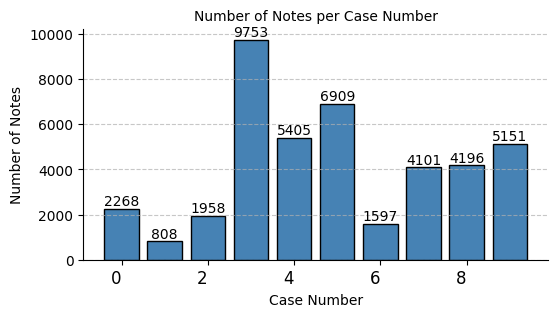

In [54]:
case_nums = case_cnt["case_num"]
counts = case_cnt["count"]

plt.figure(figsize=(6,3))
bars = plt.bar(
    case_nums, counts, color="#4682B4", edgecolor="black"
)

plt.xlabel("Case Number", fontsize=10)
plt.ylabel("Number of Notes", fontsize=10)
plt.title("Number of Notes per Case Number", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(ha="right", fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

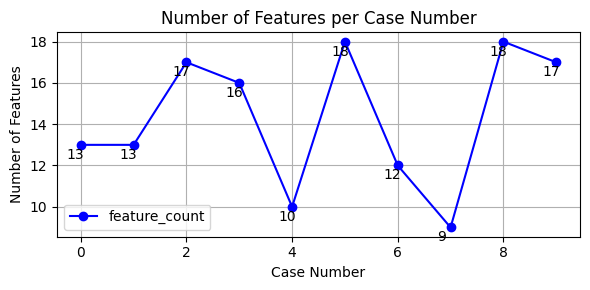

In [26]:
# Assuming 'features_df' is your DataFrame containing the data
identified_features_per_case_cnt = pd.DataFrame(
    features_df.groupby(["case_num"])["case_num"].count()
)

# Rename the column to something meaningful
identified_features_per_case_cnt.columns = ["feature_count"]

# Plotting
identified_features_per_case_cnt.plot(
    kind="line", figsize=(6, 3), marker="o", color="b"
)
plt.xlabel("Case Number")
plt.ylabel("Number of Features")
plt.title("Number of Features per Case Number")
plt.grid(True)
# Annotating data points
for idx, val in identified_features_per_case_cnt.iterrows():
    plt.annotate(
        str(val["feature_count"]),
        xy=(idx, val["feature_count"]),
        xytext=(-10, -10),
        textcoords="offset points",
    )
plt.tight_layout()

plt.show()

#### Tokenizer - Bio_Clinical

In [27]:
from transformers import AutoTokenizer, AutoModel, AutoConfig

c:\Users\punya\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [29]:
def transform_by_patient(df):
    df_new = pd.DataFrame(df.pn_num.unique(), columns=["pn_num"])
    df["location_span"] = df.location.apply(ast.literal_eval)

    location_lst = []
    notes = []
    case = []
    for num in df.pn_num.unique():
        idx = df.pn_num == num
        locations = df.loc[idx, ["feature_num", "location_span"]]
        notes.append(df.pn_history[idx].tolist()[0])
        case.append(df.case_num[idx].tolist()[0])
        location_flat = {}
        for _, feat, loc in locations.itertuples():
            location_flat[feat] = loc
        location_lst.append(location_flat)

    df_new["case_num"] = case
    df_new["location_lst"] = location_lst
    df_new["pn_history"] = notes
    note_lens = []

    for note in notes:
        token_lst = tokenizer.tokenize(note)
        note_len = len(token_lst)
        note_lens.append(note_len)

    df_new["note_lens"] = note_lens
    feat_lens = []
    for location in df_new.location_lst:
        instance_len = [feat for feat, value in location.items() if value]
        feat_lens.append(len(instance_len))

    df_new["feat_lens"] = feat_lens

    return df_new

In [30]:
df_patient = transform_by_patient(df)

Text(0, 0.5, 'Count')

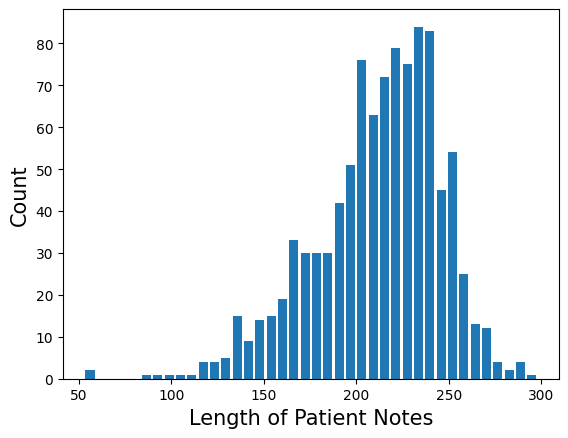

In [31]:
note_lens = np.array(df_patient.note_lens)
n, bins, patches = plt.hist(note_lens, bins=40, rwidth=0.8)
plt.xlabel("Length of Patient Notes", fontsize=15)
plt.ylabel("Count", fontsize=15)

In [32]:
print(f"Max note length: {np.max(note_lens)}")
print(f"Average noken length: {np.mean(note_lens)}")
print(f"Median noken length: {np.median(note_lens)}")

Max note length: 298
Average noken length: 211.663
Median noken length: 217.0


In [33]:
case_num = pd.DataFrame(df_patient.groupby(["case_num"])["case_num"].count())

In [34]:
case_num["avg_note_lens"] = (
    df_patient.groupby(["case_num"])["note_lens"].mean().tolist()
)
case_num["feature_num"] = features_df.groupby(["case_num"])["feature_num"].count().tolist()
case_num["avg_anno"] = df_patient.groupby(["case_num"])["feat_lens"].mean().tolist()

In [35]:
case_num.rename(columns={"case_num": "count"}, inplace=True)
case_num

,count,avg_note_lens,feature_num,avg_anno
case_num,,,,
0,100,209.33,13,9.98
1,100,217.48,13,9.42
2,100,225.88,17,9.98
3,100,204.11,16,11.98
4,100,203.12,10,7.46
5,100,210.29,18,11.74
6,100,212.39,12,9.71
7,100,215.58,9,6.92
8,100,224.19,18,11.90


#### Tokenizer - DeBerta

In [36]:
from transformers import DebertaModel, DebertaTokenizerFast

In [37]:
tokenizer = DebertaTokenizerFast.from_pretrained("microsoft/deberta-base")

In [38]:
def transform_by_patient(df):
    df_new = pd.DataFrame(df.pn_num.unique(), columns=["pn_num"])
    df["location_span"] = df.location.apply(ast.literal_eval)

    location_lst = []
    notes = []
    case = []
    for num in df.pn_num.unique():
        idx = df.pn_num == num
        locations = df.loc[idx, ["feature_num", "location_span"]]
        notes.append(df.pn_history[idx].tolist()[0])
        case.append(df.case_num[idx].tolist()[0])
        location_flat = {}
        for _, feat, loc in locations.itertuples():
            location_flat[feat] = loc
        location_lst.append(location_flat)

    df_new["case_num"] = case
    df_new["location_lst"] = location_lst
    df_new["pn_history"] = notes
    note_lens = []

    for note in notes:
        token_lst = tokenizer.tokenize(note)
        note_len = len(token_lst)
        note_lens.append(note_len)

    df_new["note_lens"] = note_lens
    feat_lens = []
    for location in df_new.location_lst:
        instance_len = [feat for feat, value in location.items() if value]
        feat_lens.append(len(instance_len))

    df_new["feat_lens"] = feat_lens

    return df_new

In [39]:
df_patient = transform_by_patient(df)

Text(0, 0.5, 'Count')

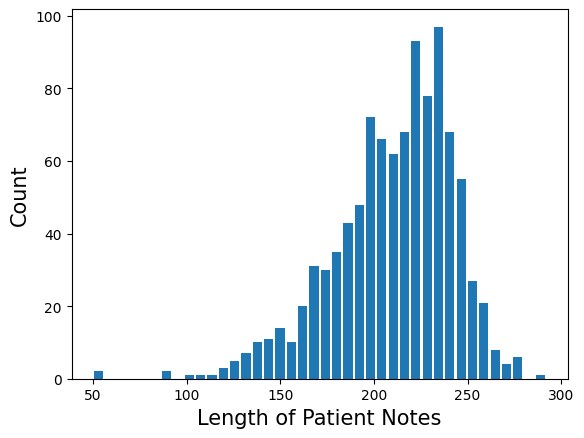

In [40]:
note_lens = np.array(df_patient.note_lens)
n, bins, patches = plt.hist(note_lens, bins=40, rwidth=0.8)
plt.xlabel("Length of Patient Notes", fontsize=15)
plt.ylabel("Count", fontsize=15)

In [41]:
print(f"Max note length: {np.max(note_lens)}")
print(f"Average noken length: {np.mean(note_lens)}")
print(f"Median noken length: {np.median(note_lens)}")

Max note length: 292
Average noken length: 210.427
Median noken length: 216.0


In [42]:
case_num = pd.DataFrame(df_patient.groupby(["case_num"])["case_num"].count())

In [43]:
case_num["avg_note_lens"] = (
    df_patient.groupby(["case_num"])["note_lens"].mean().tolist()
)
case_num["feature_num"] = features_df.groupby(["case_num"])["feature_num"].count().tolist()
case_num["avg_anno"] = df_patient.groupby(["case_num"])["feat_lens"].mean().tolist()

In [44]:
case_num.rename(columns={"case_num": "count"}, inplace=True)
case_num

,count,avg_note_lens,feature_num,avg_anno
case_num,,,,
0,100,211.19,13,9.98
1,100,215.51,13,9.42
2,100,219.44,17,9.98
3,100,208.11,16,11.98
4,100,203.27,10,7.46
5,100,208.86,18,11.74
6,100,211.41,12,9.71
7,100,211.19,9,6.92
8,100,220.28,18,11.90


### SAMPLE SUBMISSION
--------

5 rows<br>
2 columns:  
<ol>
 <li>id : submission number<br>5 unique vals
 </li>  
 <li>location : **idk what this represents**<br>3 unique vals, some NaN(blank) values</li>  

 </ol>

In [45]:
print(samplesub_df.head(5))
print(samplesub_df.columns)
print(len(samplesub_df))
for col in samplesub_df.columns:
    print(col, samplesub_df[col].nunique())

          id         location
0  00016_000            0 100
1  00016_001              NaN
2  00016_002  200 250;300 400
3  00016_003              NaN
4  00016_004           75 110
Index(['id', 'location'], dtype='object')
5
id 5
location 3
